<a href="https://colab.research.google.com/github/kartika-nair/CAPTCHA-Solver/blob/master/MixedDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports, paths, defined variables

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

import cv2
from google.colab.patches import cv2_imshow

In [3]:
data_path = "/content/drive/MyDrive/Colab Notebooks/MixedDatasets/CaptchaImages"
path_to_model = "/content/drive/MyDrive/Colab Notebooks/MixedDatasets/weights.pt"

WIDTH = 200
HEIGHT = 50

batch_size = 6
num_epochs = 41
lr = 0.001
weight_decay = 1e-3
clip_norm = 5
rnn_hidden_size = 256
threshold = 99
dropout = 0.5

Pre-Processing

In [4]:
cpu_count = mp.cpu_count()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

In [5]:
image_fns = os.listdir(data_path)

In [6]:
image_fns_train, image_fns_test = train_test_split(image_fns, random_state=0)

In [7]:
image_ns = [image_fn.split(".")[0] for image_fn in image_fns]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))

In [8]:
letters

['2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'J',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'm',
 'n',
 'p',
 'w',
 'x',
 'y']

In [9]:
vocabulary = ["-"] + letters
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
char2idx = {v:k for k,v in idx2char.items()}
num_chars = len(char2idx)

Loading Dataset

In [10]:
class CAPTCHADataset(Dataset):
  def __init__(self, data_dir, image_fns, threshold = threshold, kernel = kernel):
    self.data_dir = data_dir
    self.image_fns = image_fns
    self.threshold = threshold
    self.kernel = kernel
      
  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.data_dir, image_fn)
    image = cv2.imread(image_fp)
    image = self.transform(image)
    text = image_fn.split(".")[0]
    return image, text
  
  def transform(self, image):
    image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (WIDTH, HEIGHT))

    ret, image = cv2.threshold(image, self.threshold, 255, cv2.THRESH_BINARY_INV)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, self.kernel)
    
    transform_ops = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.456), std=(0.2245))])
    return transform_ops(image)

In [11]:
trainset = CAPTCHADataset(data_path, image_fns_train) 
testset = CAPTCHADataset(data_path, image_fns_test)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)

Model

In [12]:
resnet = resnet18(pretrained=True)

class CRNN(nn.Module):
  def __init__(self, num_chars, dropout=dropout):    
    super(CRNN, self).__init__()
    self.num_chars = num_chars
    self.dropout = dropout

    # CNN Part 1
    self.cnn_p0 = nn.Sequential(nn.Conv2d(1, 3, kernel_size = (3,6), stride = 1, padding = 1), nn.BatchNorm2d(3), nn.ReLU(inplace = True))
    
    # CNN Part 2
    resnet_modules = list(resnet.children())[:-3]
    self.cnn_p1 = nn.Sequential(*resnet_modules)
    
    # CNN Part 3
    self.cnn_p2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size = (3,6), stride = 1, padding = 1), nn.BatchNorm2d(256), nn.ReLU(inplace = True))
    
    self.linear1 = nn.Linear(1024, 256)
    
    # # RNN
    self.rnn1 = nn.GRU(input_size = rnn_hidden_size, hidden_size = rnn_hidden_size, bidirectional = True, batch_first = True)
    # self.rnn2 = nn.GRU(input_size = rnn_hidden_size, hidden_size = rnn_hidden_size, bidirectional = True, batch_first = True)
    self.linear2 = nn.Linear(256, num_chars)
        
        
  def forward(self, batch):
    batch = self.cnn_p0(batch)
    batch = self.cnn_p1(batch)
    batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
    
    batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
      
    batch_size = batch.size(0)
    T = batch.size(1)
    batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
    batch = self.linear1(batch)
    
    batch, hidden = self.rnn1(batch)
    feature_size = batch.size(2)
    batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
    # batch, hidden = self.rnn2(batch)

    batch = self.linear2(batch)
    batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
    
    return batch

In [13]:
def weights_init(m):
  classname = m.__class__.__name__
  if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
    torch.nn.init.xavier_uniform_(m.weight)
    if m.bias is not None:
      m.bias.data.fill_(0.01)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)

In [14]:
def encode_text_batch(text_batch): 
  text_batch_targets_lens = [len(text) for text in text_batch]
  text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
  
  text_batch_concat = "".join(text_batch)
  text_batch_targets = [char2idx[c] for c in text_batch_concat]
  text_batch_targets = torch.IntTensor(text_batch_targets)
  
  return text_batch_targets, text_batch_targets_lens

In [15]:
def compute_loss(text_batch, text_batch_logits):
  text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
  text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), fill_value=text_batch_logps.size(0), dtype=torch.int32).to(device) # [batch_size] 

  text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
  loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

  return loss

In [16]:
crnn = CRNN(num_chars)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [17]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)
criterion = nn.CTCLoss(blank=0)

Training

In [18]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
  epoch_loss_list = [] 
  num_updates_epoch = 0
  for image_batch, text_batch in tqdm(train_loader, leave=False):
    optimizer.zero_grad()
    text_batch_logits = crnn(image_batch.to(device))
    loss = compute_loss(text_batch, text_batch_logits)
    iteration_loss = loss.item()

    if np.isnan(iteration_loss) or np.isinf(iteration_loss):
      continue
      
    num_updates_epoch += 1
    iteration_losses.append(iteration_loss)
    epoch_loss_list.append(iteration_loss)
    loss.backward()
    nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
    optimizer.step()

  epoch_loss = np.mean(epoch_loss_list)
  print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
  epoch_losses.append(epoch_loss)
  num_updates_epochs.append(num_updates_epoch)
  lr_scheduler.step(epoch_loss)

Epoch:1    Loss:3.75748960918455    NumUpdates:268


Epoch:2    Loss:3.450087202129079    NumUpdates:268


Epoch:3    Loss:3.1999515971141075    NumUpdates:268


Epoch:4    Loss:2.9228156858415746    NumUpdates:268


Epoch:5    Loss:2.628113331634607    NumUpdates:268


Epoch:6    Loss:2.4077474506043677    NumUpdates:268


Epoch:7    Loss:2.168042653754576    NumUpdates:268


Epoch:8    Loss:1.8371541580157493    NumUpdates:268


Epoch:9    Loss:1.3580142946830436    NumUpdates:268


Epoch:10    Loss:0.9803128740680751    NumUpdates:268


Epoch:11    Loss:0.7390241996565862    NumUpdates:268


Epoch:12    Loss:0.5208757406295236    NumUpdates:268


Epoch:13    Loss:0.39483779857852563    NumUpdates:268


Epoch:14    Loss:0.3292891675495167    NumUpdates:268


Epoch:15    Loss:0.2963426217937203    NumUpdates:268


Epoch:16    Loss:0.26589888562239816    NumUpdates:268


Epoch:17    Loss:0.2472785641230754    NumUpdates:268


Epoch:18    Loss:0.2396284688486537    NumUpdates:268


Epoch:19    Loss:0.1860280593356757    NumUpdates:268


Epoch:20    Loss:0.17491284252227798    NumUpdates:268


Epoch:21    Loss:0.15383120000000988    NumUpdates:268


Epoch:22    Loss:0.16625004864311707    NumUpdates:268


Epoch:23    Loss:0.14282619333548    NumUpdates:268


Epoch:24    Loss:0.18109944874573666    NumUpdates:268


Epoch:25    Loss:0.14445559185957396    NumUpdates:268


Epoch:26    Loss:0.13362152564492244    NumUpdates:268


Epoch:27    Loss:0.10784612450342097    NumUpdates:268


Epoch:28    Loss:0.1409745272075229    NumUpdates:268


Epoch:29    Loss:0.1221831176680193    NumUpdates:268


Epoch:30    Loss:0.10830730532553158    NumUpdates:268


Epoch:31    Loss:0.10472594736554007    NumUpdates:268


Epoch:32    Loss:0.07417449327324753    NumUpdates:268


Epoch:33    Loss:0.14523730212787805    NumUpdates:268


Epoch:34    Loss:0.11555620445001091    NumUpdates:268


Epoch:35    Loss:0.08411854479562686    NumUpdates:268


Epoch:36    Loss:0.07326448938301973    NumUpdates:268


Epoch:37    Loss:0.10003253338691681    NumUpdates:268


Epoch:38    Loss:0.09290543012842258    NumUpdates:268


Epoch:39    Loss:0.08625117340212021    NumUpdates:268


Epoch:40    Loss:0.10732337611696141    NumUpdates:268


Epoch:41    Loss:0.08078121887902215    NumUpdates:268



Loss Graphs

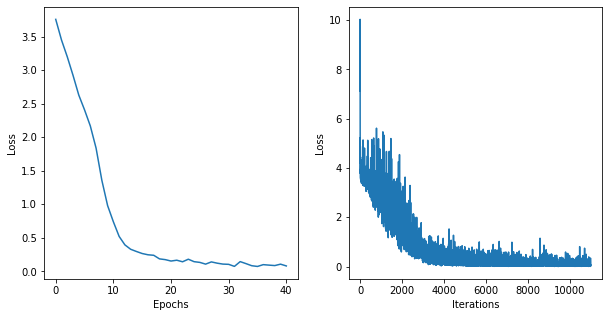

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

Getting Accuracy

In [20]:
def decode_predictions(text_batch_logits):

  text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
  text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

  text_batch_tokens_new = []
  for text_tokens in text_batch_tokens:
    text = [idx2char[idx] for idx in text_tokens]
    text = "".join(text)
    text_batch_tokens_new.append(text)

  return text_batch_tokens_new

In [21]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)

with torch.no_grad():
  for image_batch, text_batch in tqdm(train_loader, leave=True):
    text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
    text_batch_pred = decode_predictions(text_batch_logits.cpu())
    df = pd.DataFrame(columns=['actual', 'prediction'])
    df['actual'] = text_batch
    df['prediction'] = text_batch_pred
    results_train = pd.concat([results_train, df])
    
results_train = results_train.reset_index(drop=True)

In [22]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)

with torch.no_grad():
  for image_batch, text_batch in tqdm(test_loader, leave=True):
    text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
    text_batch_pred = decode_predictions(text_batch_logits.cpu())
    df = pd.DataFrame(columns=['actual', 'prediction'])
    df['actual'] = text_batch
    df['prediction'] = text_batch_pred
    results_test = pd.concat([results_test, df])

results_test = results_test.reset_index(drop=True)

In [23]:
def remove_duplicates(text):
  if len(text) > 1:
    letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
  elif len(text) == 1:
    letters = [text[0]]
  else:
    return ""
  return "".join(letters)

def correct_prediction(word):
  parts = word.split("-")
  parts = [remove_duplicates(part) for part in parts]
  corrected_word = "".join(parts)
  return corrected_word

In [24]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)

In [25]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.9482866043613707
0.7850467289719626


In [26]:
torch.save(crnn, path_to_model)